In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, List

#! -------------------------------------------------------
os.environ['QES_BACKEND'] = 'numpy'   # Backend for numerical operations
os.environ['QES_LOGFILE'] = '0'       # Disable logging to file
#! -------------------------------------------------------

# add to directory
cwd             = Path(os.getcwd())
mod_path        = Path(os.curdir).resolve()
file_path       = mod_path.parent
qes_path        = file_path.parent.parent.parent.parent
data_path       = file_path.parent
qes_lib_path    = qes_path / "QES"
gen_lib_path    = qes_lib_path / "general_python"
print(f"-> CWD: {cwd}")
print(f"-> Module Path: {mod_path}")
print(f"-> File Path: {file_path}")
print(f"-> QES Path: {qes_path}")
print(f"-> QES Lib Path: {qes_lib_path}")
print(f"-> General Lib Path: {gen_lib_path}")
sys.path.insert(0, str(qes_path))
sys.path.insert(0, str(qes_lib_path))
sys.path.insert(0, str(gen_lib_path))

# --------------------------------------
from QES.general_python.common.plot import Plotter
from QES.general_python.common.directories import Directories
from QES.general_python.common.hdf5_lib import HDF5Handler
from QES.general_python.common.hdf5man import HDF5Manager
from QES.Algebra.hamil import Hamiltonian
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.Model.Noninteracting.plrb import PowerLawRandomBanded
# --------------------------------------
from QES.general_python.maths.statistics import HistogramAverage
from QES.Algebra.Properties import statistical
from QES.general_python.physics import entropy
from QES.general_python.maths.statistics import sliding_window_view
# --------------------------------------

typek           = "uniform"
model           = "um"

def repr(model: str, ns: int, param: float, **kwargs):
    if model == 'um' or model == 'ultrametric':
        return UltrametricModel.repr(ns=ns, n=kwargs.get('n', 1), J=kwargs.get('J', 1.0), g=kwargs.get('g', 1.0), alphas=param)
    elif model == 'plrb' or model == 'powerlaw':
        return PowerLawRandomBanded.repr(ns=ns, many_body=True, a=param, b=1.0)
    else:
        raise ValueError(f"Unknown model: {model}")
    
# --------------------------------------

stat_start      = "stat_"
diag_start      = "diag_"
fidl_start      = "fid_"
hist_start      = "hist_"
evol_start      = "evo_"
operator        = 'Sz/0'
# --------------------------------------
time_key        = '/time'
time_evo_key    = lambda operator: f'/time_evolution/{operator}/expectation'
time_evo_d_key  = lambda operator: f'/time_evolution/{operator}/diag_ens'
time_evo_e_key  = f'/time_evolution/quench/energy'
# --------------------------------------
energy_key      = '/energies'
ldos_key        = '/ldos'
vn_key          = '/entropy/quench/von_neumann/1.0'
tsalis_key      = '/entropy/quench/tsallis/2.0'
schmidt_gap_key = '/entropy/quench/schmidt_gap'
# --------------------------------------

f_fun_key       = lambda op: f'/historgram/{op}/average/values'
f_fun_full_key  = lambda op: f'/historgram/{op}/full/average/values'

k_fun_key       = f'/k_function/values'
k_fun_full_key  = f'/k_function/full/values'

k_f_key         = lambda op: f'/k_times_f/{op}/values'
k_f_full_key    = lambda op: f'/k_times_f/{op}/full/values'
k_f_mix_key     = lambda op: f'/k_times_f/{op}/mix/values'

s_fun_key       = lambda op: f'/s_function/{op}/values'
s_fun_full_key  = lambda op: f'/s_function/{op}/full/values'

om_key          = f'/historgram/edges'

fft_val_key     = lambda op: f'/fft/{op}/fft'
fft_om_key      = f'/fft/fft_omega'


-> CWD: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/plot/august_2025
-> Module Path: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/plot/august_2025
-> File Path: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/plot
-> QES Path: /home/klimak/Codes/QuantumEigenSolver/Python
-> QES Lib Path: /home/klimak/Codes/QuantumEigenSolver/Python/QES
-> General Lib Path: /home/klimak/Codes/QuantumEigenSolver/Python/QES/general_python
03_09_2025_10-08_16 [INFO] ############Global Logger initialized!############


In [2]:
def process_hist(x, y, mean: bool = True, validate: bool = True, normalize: bool = True):
    """
    x: (G,)
    y: (G,) or (R,G). If mean=True and y is 2D, average over axis=0 first.
    Returns (y_new, x_new) with bad bins removed and (optionally) normalized.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # mean over realizations if requested
    if mean and y.ndim >= 2:
        y = np.mean(y, axis=0)

    # sort by x if not monotonic (preserves alignment)
    if x.ndim != 1:
        x = x.reshape(-1)
        
    if np.any(np.diff(x) < 0):
        idx = np.argsort(x)
        x   = x[idx]
        y   = y[..., idx]

    # validation mask
    if validate:
        if y.ndim == 1:
            mask = np.isfinite(x) & np.isfinite(y)
        else:
            mask = np.isfinite(x) & np.all(np.isfinite(y), axis=0)
        x_new = x[mask]
        y_new = y[..., mask]
    else:
        x_new, y_new = x, y

    # remove empty
    if x_new.size == 0:
        return y_new, x_new

    # normalization
    if normalize:
        if y_new.ndim == 1:
            area = np.trapz(y_new, x=x_new)
            if np.isfinite(area) and area != 0.0:
                y_new = y_new / area
        else:
            areas = np.trapz(y_new, x=x_new, axis=-1)
            # avoid divide-by-zero
            areas = np.where((np.isfinite(areas) & (areas != 0.0)), areas, 1.0)
            y_new = y_new / areas[..., None]

    return y_new, x_new

### Fluctuations

In [40]:


data_dir            = Directories(data_path / "data_big_times_test" / typek)
model_directories   = data_dir.list_dirs(as_string=True)
alphas              = [0.700, 0.740, 0.820, 0.860, 0.900, 0.940]
nss                 = [8, 9, 10, 11, 12, 13, 14, 15]

nss_alpha           = { alpha : [] for alpha in alphas }
sigma_ts            = { alpha : [] for alpha in alphas }
p2s                 = { alpha : [] for alpha in alphas }

# quick check of sigma_t
sigma_ts_init       = { alpha : [[] for _ in range(5)] for alpha in alphas }


for alpha in alphas:
    for ns in nss:
        hilbert_dim = 2**ns
        model_str   = repr(model=model, ns=ns, param=alpha, n=1)
        dir_in      = data_dir / model_str
        if not dir_in.exists():
            continue
        # evolution
        evo_files   = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: evol_start in str(x)])
        if len(evo_files) == 0:
            continue
        evo_data    = HDF5Manager.load_data_from_multiple_files(file_paths      = evo_files,
                                                                dataset_keys    = [time_key, time_evo_key(operator), time_evo_d_key(operator)],)
        evo_data_t  = proces_data(evo_data, time_key, unpack=False)[0]
        evo_data_q  = proces_data(evo_data, time_evo_key(operator))

        # energies
        stat_files  = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: stat_start in str(x)])
        en_data     = HDF5Manager.load_data_from_multiple_files(file_paths      = stat_files,
                                                                dataset_keys    = [energy_key, ldos_key],)
        en_data_v               = proces_data(en_data, energy_key)
        differences             = np.diff(en_data_v, axis = 1)
        mean_lvl_spacing        = np.mean(differences, axis = 1) # mean level spacing over all samples
        heisenberg_time         = np.mean(2 * np.pi / mean_lvl_spacing)
        
        #! IPRS from the LDOS
        data_ldos               = proces_data(en_data, ldos_key)
        qs                      = [0.5, 1.0, 2.0, 3.0, 4.0] # divide by 2, as we have the LDOS, which is already squared - IPRS for quench
        iprs                    = { q: statistical.inverse_participation_ratio(data_ldos.T, q = q / 2) for q in qs }
        participation_entropies = { q: entropy.participation_entropy(data_ldos.T, q = q / 2) for q in qs }
        p2s[alpha].append(np.mean(iprs[2.0]))
        
        #! fluctuations        
        nss_alpha[alpha].append(ns)
        ts_start                = np.argmin(np.abs(heisenberg_time - evo_data_t))
        evo_data_cut            = evo_data_q[:, ts_start:]
        evo_data_cut_t          = evo_data_t[ts_start:]
        sigma_t                 = np.mean(np.var(evo_data_cut, axis = 1))
        sigma_ts[alpha].append(sigma_t)
        tstarts                 = [evo_data_t[0], heisenberg_time / 5, heisenberg_time / 2, heisenberg_time, 2*heisenberg_time]
        for it, tstart in enumerate(tstarts):
            ts_start                = np.argmin(np.abs(tstart - evo_data_t))
            evo_data_cut            = evo_data_q[:, ts_start:]
            evo_data_cut_t          = evo_data_t[ts_start:]
            sigma_t                 = np.mean(np.var(evo_data_cut, axis = 1))
            sigma_ts_init[alpha][it].append(sigma_t)
        
        

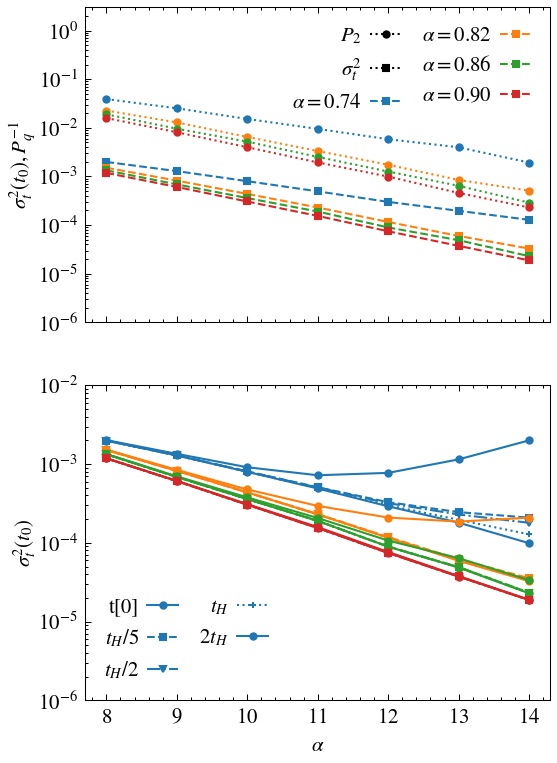

In [43]:
fig, ax = Plotter.get_subplots(nrows=2, ncols=1, sizex=4, sizey=6, dpi=150, sharex=True)

Plotter.plot(ax[0], [None], [None], ms = 3, ls = ':', lw = 1, marker = 'o', color = 'black', label = r'$P_2$')
Plotter.plot(ax[0], [None], [None], ms = 3, ls = ':', lw = 1, marker = 's', color = 'black', label = r'$\sigma_t^2$')
for ia, alpha in enumerate(alphas):
    # p2s
    Plotter.plot(ax[0], nss_alpha[alpha], p2s[alpha], ms = 3, ls = ':', lw = 1, marker = 'o', color = ia)
    Plotter.plot(ax[0], nss_alpha[alpha], sigma_ts[alpha], ms = 3,
                    ls      = '--', 
                    lw      = 1, marker = 's', color = ia,
                    label   = fr'$\alpha = {alpha:.2f}$')
    
    ######
    t0s = [r't[0]', r'$t_H/5$', r'$t_H/2$', r'$t_H$', r'$2t_H$']
    for iaa, values in enumerate(sigma_ts_init[alpha]):
        Plotter.plot(ax[1], nss_alpha[alpha], values, ms = 3,
                ls = iaa, lw = 1, marker = iaa, label = t0s[iaa], color = ia, labelcond=ia==0)
        
    
Plotter.set_legend(ax[0], ncols=2)
Plotter.set_legend(ax[1], ncols=2)
Plotter.set_ax_params(ax[0], which='y', yscale='log', ylim=(1e-6, 3e-0))
Plotter.set_ax_params(ax[1], which='y', yscale='log', ylim=(1e-6, 1e-2))
Plotter.set_ax_labels(ax[0], ylabel=r'$\sigma _t ^2 (t_0), P_q^{-1}$')
Plotter.set_ax_labels(ax[1], xlabel=r'$\alpha$', ylabel=r'$\sigma _t ^2 (t_0)$')


### f-functions, k-functions, s-functions - binned or not

[{'/historgram/Sz/0/average/values': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.68342655e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.32433611e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.38242794e-01, 2.18095226e-01, 3.23346035e-01, 9.75612644e-02,
       3.15406617e-01, 0.00000000e+00, 2.16370970e-01, 3.42562200e-01,
       2.47825131e-01, 1.87488519e-01, 5.53397126e-02, 1.86449953e-01,
       1.50823401e-01, 8.43776331e-02, 1.89397325e-01, 2.19859297e-01,
       1.18226226e-01, 1.52222925e-01, 1.68136143e-01, 1.62814315e-01,
       1.31825565e-01, 1.69430110e-01, 1

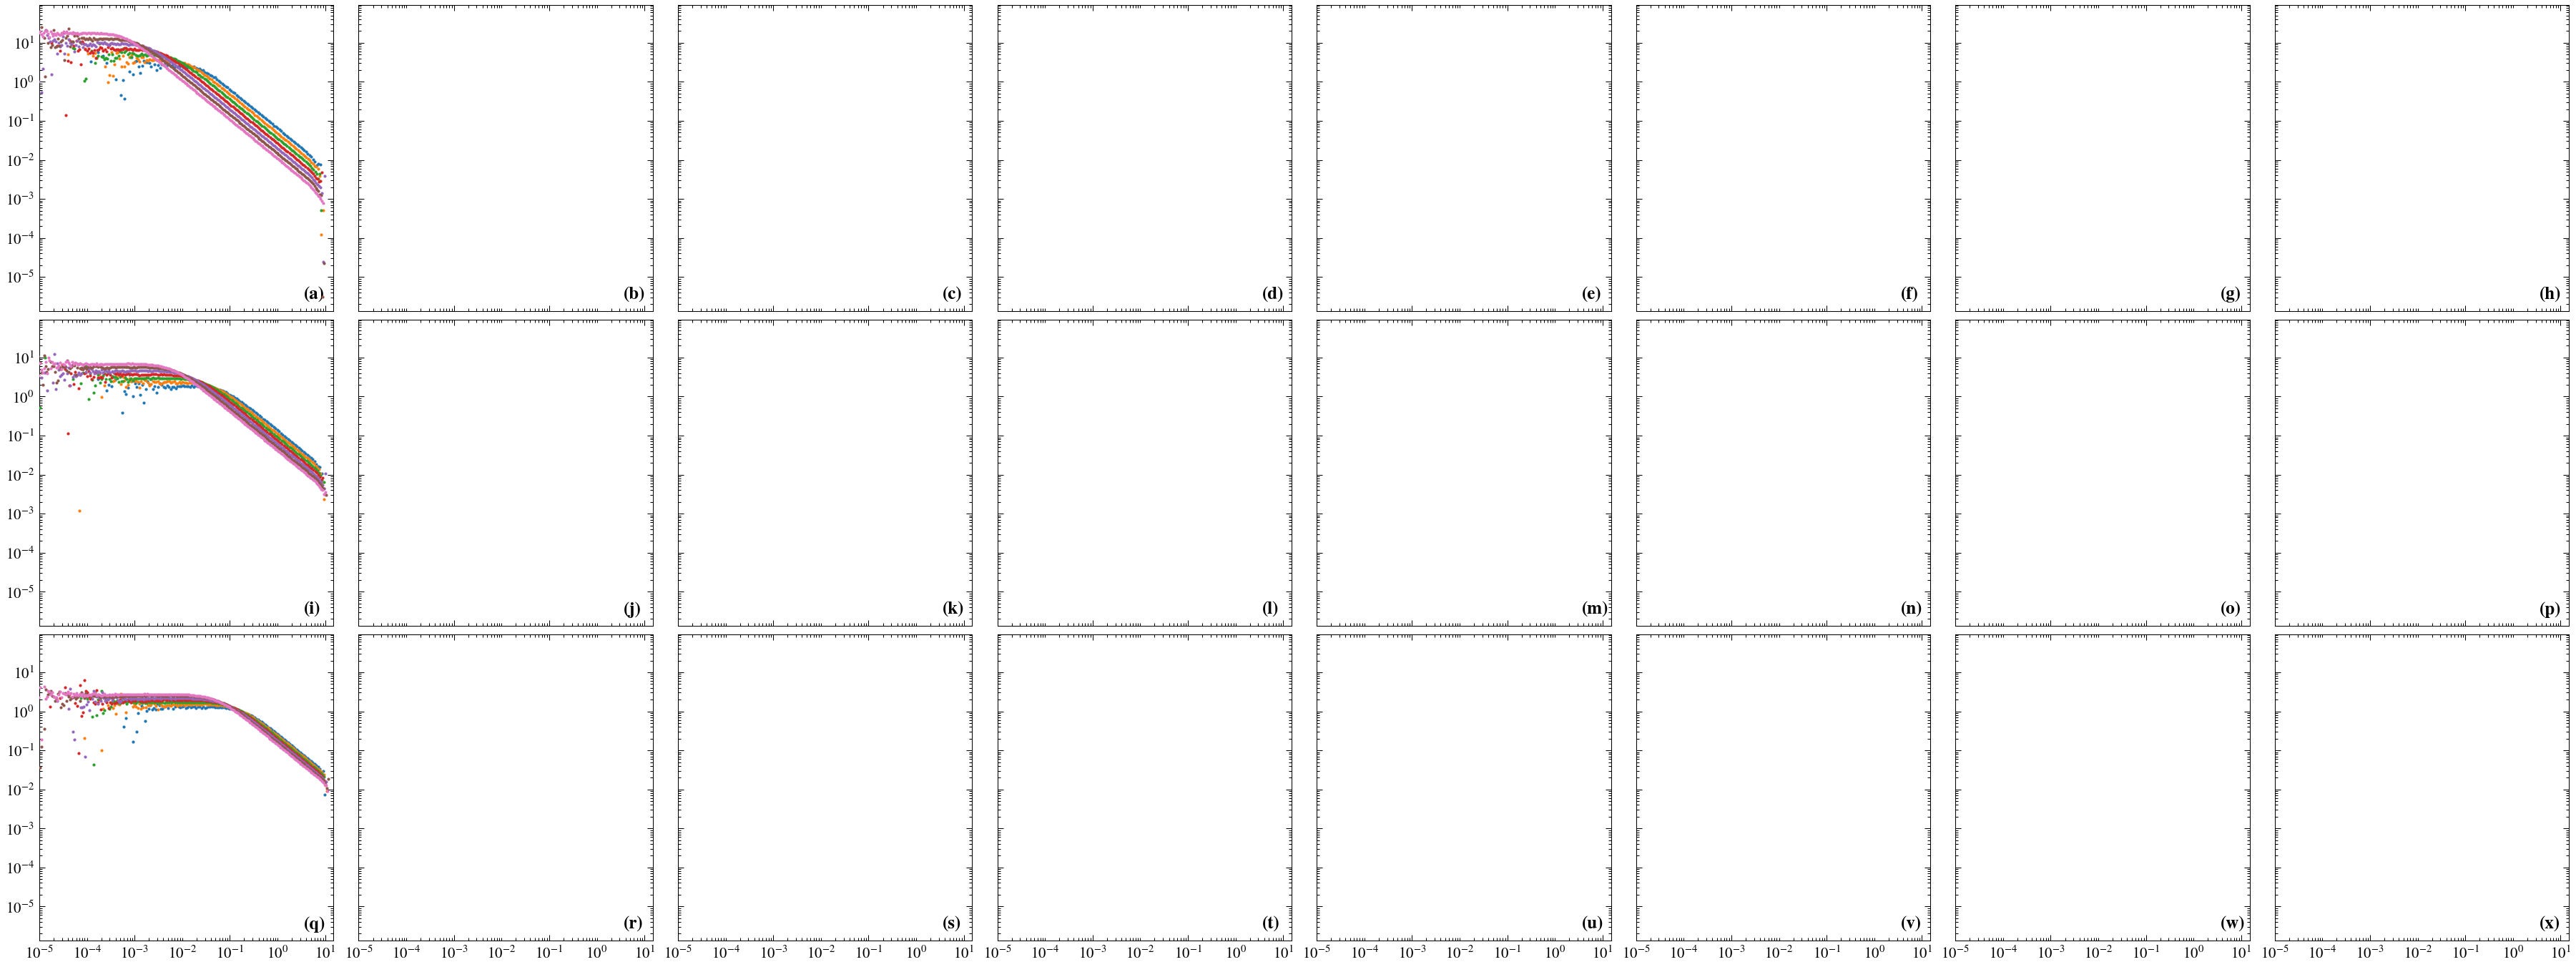

In [7]:
from matplotlib.pyplot import hist
from networkx import omega


data_dir            = Directories(data_path / "data_big_times_test" / typek)
model_directories   = data_dir.list_dirs(as_string=True)
alphas              = [0.740, 0.820, 0.900]
# alphas              = [0.700, 0.800, 0.900]
nss                 = [8, 9, 10, 11, 12, 13, 14]

cols                = [ r'$f(\omega)$', r'$f_{\rm full}(\omega)$', 
                        r'$K(\omega)$', r'$K_{\rm full}(\omega)$', 
                        r'$K(\omega) \times f(\omega)$', 
                        r'$K_{\rm full}(\omega) \times f(\omega)$', 
                        r'$S_{\rm mid}(\omega)$', 
                        r'$\mathcal{S}(\omega)$']
ncols               = len(cols)
fig, ax             = Plotter.get_subplots(nrows    =   len(alphas), 
                                        ncols       =   ncols, sharey=True, sharex=True,
                                        sizex       =   3*ncols, 
                                        sizey       =   3*len(alphas), dpi=150, 
                                        panel_labels=True, annot_x_pos=0.9, annot_y_pos=0.08)

# quick check of sigma_t
alpha_from_ns       = lambda ns: abs(ns - nss[0] + 1.0) / len(nss)
for ia, alpha in enumerate(alphas):
    for ins, ns in enumerate(nss):
        hilbert_dim = 2**ns
        model_str   = repr(model=model, ns=ns, param=alpha, n=1)
        dir_in      = data_dir / model_str
        if not dir_in.exists() or len(os.listdir(dir_in)) == 0:
            continue
    # evolution
        hist_files  = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: hist_start in str(x)])
        hist_data   = HDF5Manager.load_data_from_multiple_files(file_paths = hist_files,
                                                                dataset_keys = [f_fun_key(operator), f_fun_full_key(operator),
                                                                                k_fun_key, k_fun_full_key,
                                                                                k_f_key(operator), k_f_full_key(operator), k_f_mix_key(operator),
                                                                                s_fun_key(operator), s_fun_full_key(operator),
                                                                                om_key])
        omegas                  = hist_data[0][om_key]
        
        # f fun
        axis                    = ax[ncols * ia]
        print(hist_data)
        f_fun                   = hist_data[-1][f_fun_key(operator)]
        print(f_fun)
        Plotter.plot(axis, omegas, f_fun * np.sqrt(hilbert_dim), color=ins, label=r'$\mathcal{N}=$'+f'{ns}', marker=0,lw=0,ms=1)
        # f_fun, omegas_f         = process_hist(omegas, HDF5Manager.process_data(hist_data, f_fun_key(operator), unpack=False), normalize=False, mean=False)
        # print(f_fun)
        axis                    = ax[ncols * ia + 1]
        # f_fun_full, omegas_f    = process_hist(omegas, HDF5Manager.process_data(hist_data, f_fun_full_key(operator), unpack=False), normalize=False)
        # Plotter.plot(axis, omegas_f, f_fun_full * hilbert_dim, color=ins, label=r'$\mathcal{N}=$'+f'{ns}', marker=1,lw=0,ms=1)

        continue
        # k fun
        axis = ax[ncols * ia + 1]
        k_fun, omegas_k         = process_hist(omegas, proces_data(hist_data, k_fun_key, unpack=False), normalize = False, mean=False)
        k_fun                   = np.mean(k_fun, axis = 0)
        Plotter.plot(axis, omegas_k, k_fun * hilbert_dim,
                    color=ins, alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}', marker='v',lw=0,ms=1)
        k_fun_full, omegas_k    = process_hist(omegas, proces_data(hist_data, k_fun_full_key, unpack=False), normalize = False)
        Plotter.plot(axis, omegas_k, k_fun_full * mult * hilbert_dim,
                    color='gray', alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}', marker='o', lw=0,ms=1)

        # k_times_f
        axis = ax[ncols * ia + 2]
        k_times_f, omegas_k     = process_hist(omegas, proces_data(hist_data, k_f_key(operator), unpack=False) * hilbert_dim**2, normalize = False)
        Plotter.plot(axis, omegas_k, k_times_f, color=ins, alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}', marker='v',lw=0,ms=1)      
        k_times_f, omegas_k     = process_hist(omegas, proces_data(hist_data, k_f_full_key(operator), unpack=False) * hilbert_dim**2, normalize = False)
        Plotter.plot(axis, omegas_k, k_times_f*mult, color='gray', alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}', marker='v',lw=0,ms=1)      
        k_times_f, omegas_k     = process_hist(omegas, proces_data(hist_data, k_f_mix_key(operator), unpack=False) * hilbert_dim**2, normalize = False)
        Plotter.plot(axis, omegas_k, k_times_f*mult*mult, color='black', alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}', marker='v',lw=0,ms=1)
        
        # s_function
        axis = ax[ncols * ia + 3]
        s_fun, omegas_s         = process_hist(omegas, proces_data(hist_data, s_fun_key(operator), unpack=False), normalize = False)
        Plotter.plot(axis, omegas_s, s_fun, color=ins, label=r'$\mathcal{N}=$'+f'{ns}',marker=0,lw=0,ms=1)  
        s_fun, omegas_s         = process_hist(omegas, proces_data(hist_data, s_fun_full_key(operator), unpack=False), normalize = False)
        Plotter.plot(axis, omegas_s, s_fun*mult,
                    color='gray', alpha=alpha_from_ns(ns),
                    label=r'$\mathcal{N}=$'+f'{ns}',marker=1,lw=0,ms=1)     
        
        # omega^{-2}
        axis = ax[ncols * ia + 2]
        Plotter.plot(axis, omegas_k, omegas_k**(-2), lw=1, color='gray')
        Plotter.plot(axis, omegas_k, omegas_k**(-1.5), lw=1, color='blue')
        Plotter.plot(axis, omegas_k, omegas_k**(-1), lw=1, color='black')
        axis = ax[ncols * ia + 3]
        Plotter.plot(axis, omegas_k, omegas_k**(-2), lw=1, color='gray')
        Plotter.plot(axis, omegas_k, omegas_k**(-1.5), lw=1, color='blue')
        Plotter.plot(axis, omegas_k, omegas_k**(-1), lw=1, color='black')
        
        #! energies ------------------
        stat_files              = HDF5Handler.file_list_matching(directories = dir_in, 
                                                                conditions   = [lambda x: stat_start in str(x)])
        en_data                 = HDF5Manager.load_data_from_multiple_files(file_paths      = stat_files,
                                                                            dataset_keys    = [energy_key, ldos_key],)
        en_data_v               = proces_data(en_data, energy_key)
        differences             = np.diff(en_data_v, axis = 1)
        mean_lvl_spacing        = np.mean(differences, axis = 1) # mean level spacing over all samples
        heisenberg_time         = np.mean(2 * np.pi / mean_lvl_spacing)

        # fourier ------------------
        evol_files      = HDF5Handler.file_list_matching(directories = dir_in, 
                                                        conditions   = [lambda x: evol_start in str(x)])
        evol_data       = HDF5Manager.load_data_from_multiple_files(file_paths = evol_files,
                                                                dataset_keys = [fft_val_key(operator), fft_om_key]) 
        # evol_data       = HDF5Manager.load_data_from_multiple_files(file_paths = evol_files,
        #                                                         dataset_keys = [time_evo_key(operator), time_key,
        #                                                                         time_evo_d_key(operator)]) 
        # evo_data_t          = proces_data(evol_data, time_key, unpack=False)[0]
        # evo_data_q          = proces_data(evol_data, time_evo_key(operator), unpack=True)
        # evo_data_d          = proces_data(evol_data, time_evo_d_key(operator), unpack=True)
        # evo_data_d          = evo_data_d.reshape(-1)
        # time_delta          = evo_data_t[1] - evo_data_t[0]

        # ts_start            = np.argmin(np.abs(heisenberg_time*5 - evo_data_t))
        # evo_data_cut        = evo_data_q[:, ts_start:]
        # evo_data_cut_t      = evo_data_t[ts_start:]
        # time_num            = evo_data_cut_t.shape[-1]
        # fft_omegas          = np.fft.rfftfreq(time_num, d=time_delta) * 2 * np.pi

        # time_num            = evo_data_cut_t.shape[0]
        # time_norm           = 2 / np.sqrt(time_num)
        # data_evo_av         = evo_data_cut - evo_data_d[:, np.newaxis]
        # data_evo_fft_base   = np.fft.rfft(data_evo_av, axis=1) * time_norm

        # data_evo_fft        = np.abs(data_evo_fft_base)**2 / time_num**2
        # data_evo_fft_n      = np.trapz(data_evo_fft, x=fft_omegas, axis=1)
        # data_evo_fft        = data_evo_fft / data_evo_fft_n[:, np.newaxis]
        # values              = np.mean(data_evo_fft, axis=0)
        # omegas              = fft_omegas

        # values              = sliding_window_view(values, 121)
        # omegas              = omegas[:-121+1]
        #! presaved
        omegas          = proces_data(evol_data, fft_om_key, unpack=False)[0]
        values          = np.mean(proces_data(evol_data, fft_val_key(operator), unpack=True), axis=0)
        values, omegas  = process_hist(omegas[2:], values, mean=False, normalize=False)
        # values, omegas  = values[::5], omegas[::5]
        axis = ax[ncols * ia + 3]
        every= 20
        Plotter.plot(axis, omegas[::every], values[::every]*mult*mult*mult, color=ins, label=r'$\mathcal{N}=$'+f'{ns}',marker=2,lw=0,ms=1)   
        
for axis in ax:
    Plotter.set_ax_params(axis, which='y', yscale='log')
    Plotter.set_ax_params(axis, which='x', xscale='log', xlim=(1e-5, 15))
    Plotter.set_tickparams(axis, maj_tick_l=4, min_tick_l=2)

# fig.tight_layout()

### LDOS

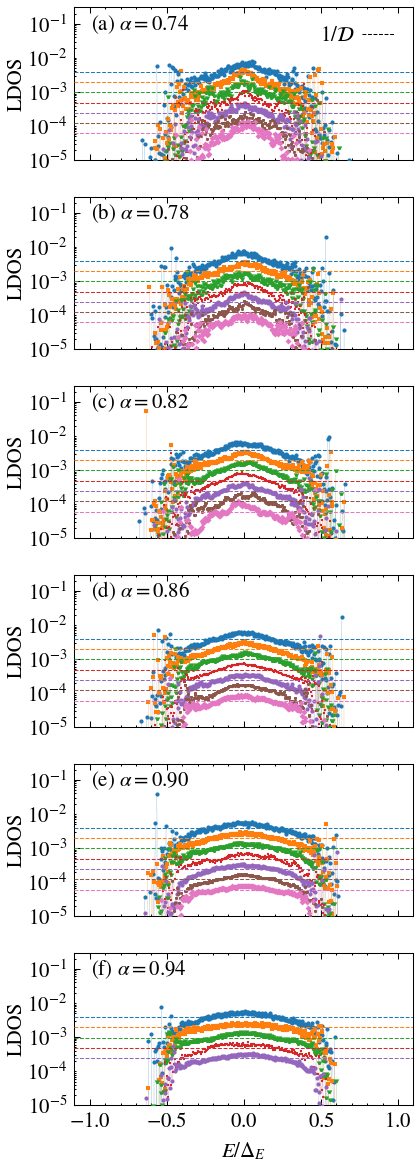

In [47]:
data_dir            = Directories(data_path / "data_big_times_test" / typek)
model_directories   = data_dir.list_dirs(as_string=True)
alphas              = [0.740, 0.780, 0.820, 0.860, 0.900, 0.940]
# alphas              = [0.700, 0.800, 0.900]
nss                 = [8, 9, 10, 11, 12, 13, 14]
fig, ax             = Plotter.get_subplots(nrows=len(alphas), ncols=1, sizex=3, sizey=8, dpi=150, sharex=True)

# for the ldos histogram
bins_ldos           = np.arange(-1, 1, 0.005)

for ia, alpha in enumerate(alphas):
    for ins, ns in enumerate(nss):
        hilbert_dim = 2**ns
        model_str   = repr(model=model, ns=ns, param=alpha, n=1)
        dir_in      = data_dir / model_str
        if not dir_in.exists() or len(os.listdir(dir_in)) == 0:
            continue

        # energies
        stat_files              = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: stat_start in str(x)])
        en_data                 = HDF5Manager.load_data_from_multiple_files(file_paths      = stat_files,
                                                                dataset_keys    = [energy_key, ldos_key],)
        en_data_v               = proces_data(en_data, energy_key)
        bw                      = np.mean(en_data_v[:, -1] - en_data_v[:, 0])
        en_data_v               = en_data_v / bw
        differences             = np.diff(en_data_v, axis = 1)
        mean_lvl_spacing        = np.mean(differences, axis = 1) # mean level spacing over all samples
        heisenberg_time         = np.mean(2 * np.pi / mean_lvl_spacing)
        
        #! IPRS from the LDOS
        data_ldos               = proces_data(en_data, ldos_key)
        hist_ldos               = HistogramAverage(edges = bins_ldos)
        for ii in range(len(data_ldos)):
            hist_ldos.append(en_data_v[ii], data_ldos[ii])
        hist_ldos               = hist_ldos.averages_av()
        # hist_ldos              /= np.trapz(hist_ldos, x=bins_ldos)
        Plotter.plot(ax[ia], bins_ldos, hist_ldos, marker=ns-8, lw=0.05, ms=1, color=ins)
        Plotter.hline(ax[ia], 1/hilbert_dim, ls='--', color=ins, lw=0.5)

Plotter.hline(ax[0], -10, color='black', lw=0.5, label=r'$1/\mathcal{D}$')
for i, axis in enumerate(ax):
    Plotter.set_tickparams(axis, maj_tick_l=3, min_tick_l=1)
    Plotter.set_annotate_letter(axis, i, x=0.05, y=0.85, fontsize=10, addit=rf' $\alpha={alphas[i]:.2f}$', boxaround=False)
    Plotter.set_ax_params(axis, which='y', yscale='log', ylim=(1e-5, 3e-1))
    Plotter.set_ax_labels(axis, xlabel=r'$E/\Delta_E$' if axis == ax[-1] else None, ylabel=r'LDOS')
    Plotter.set_legend(axis, ncols=1)

fig.tight_layout()